# Chapter 2. Small Worlds and Large Worlds

[Open in Colab](https://colab.research.google.com/github/hongsupshin/statisticalrethinking_practice/blob/main/Notebooks/Ch2.ipynb)

In [ ]:
!pip install -q numpyro arviz causalgraphicalmodels daft

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

## 2.1

In [2]:
ways = jnp.array([0.0, 3, 8, 9, 0])
ways / jnp.sum(ways)

Array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

## 2.2
Likelihood: 6 Ws in 9 tosses w/ p=0.5 (p: arbitrary probability of getting W)

In [3]:
jnp.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(6))

Array(0.16406256, dtype=float32)

Prior
- initial plausibility (some belief you have when N = 0, scientific/engineering assumptions)
- part of the model; needs to be chosen, evaluated, and revised

Likelihood
- distribution function assigned to an observed variable (how likely to get this specific observation)
- e.g., binary variable, out of 9 observations, 6 were W and 3 were L

Posterior: updated prior with likelihood

Marginal likelihood: the normalization term in posterior (marginal = average over prior)

## 2.3
How to approxiate posterior: 3 methods
1. Grid approximation
2. Quadratic approximation
3. MCMC

Grid approximation:
1. Define the grid: how many points to use in estimating the posterior
2. Compute the value of the prior at each parameter value on the grid
3. Compute the likelihood at each param value
4. Compute the unstandardized posterior at each param value (prior x likelihood)
5. Standardized the posterior (divide each value by the sum of all values)

In [4]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=20)

# define prior
prior = jnp.repeat(1, 20)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

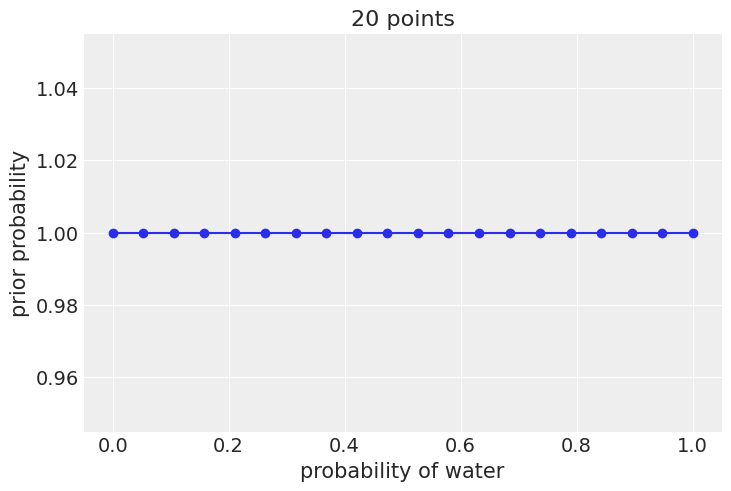

In [5]:
plt.plot(p_grid, prior, "-o")
plt.xlabel("probability of water")
plt.ylabel("prior probability")
plt.title("20 points")
plt.show()

## 2.4 posterior distribution

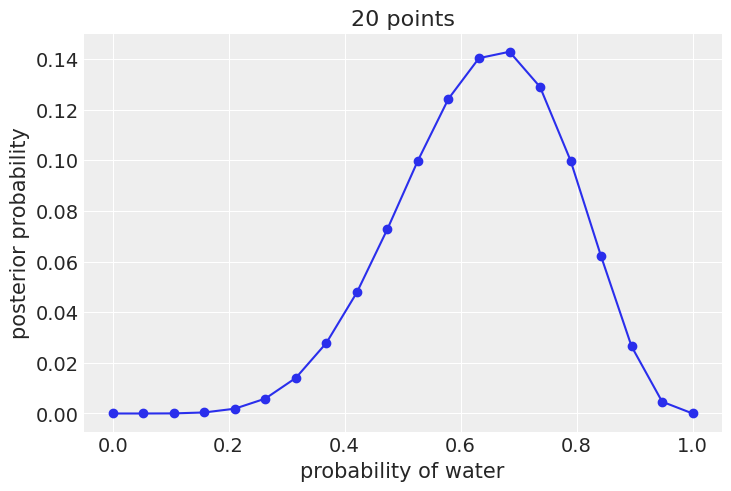

In [6]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points")
plt.show()

## 2.5 different prior

In [7]:
prior = jnp.where(p_grid < 0.5, 0, 1)
prior = jnp.exp(-5 * abs(p_grid - 0.5))

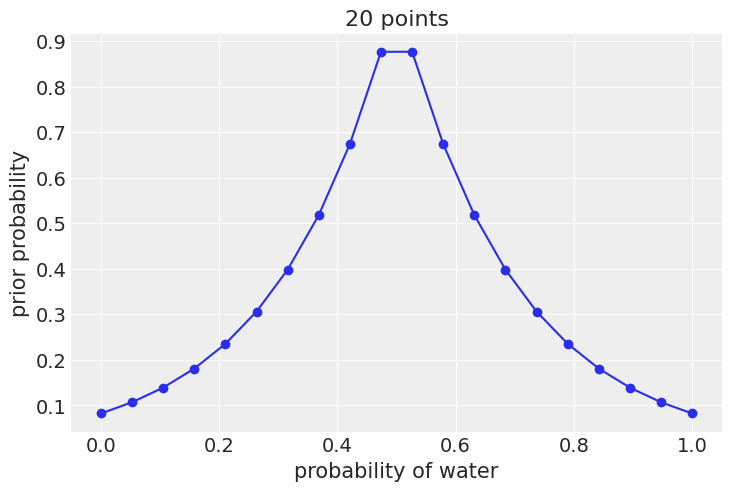

In [8]:
plt.plot(p_grid, prior, "-o")
plt.xlabel("probability of water")
plt.ylabel("prior probability")
plt.title("20 points")
plt.show()

In [9]:
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
unstd_posterior = likelihood * prior
posterior = unstd_posterior / jnp.sum(unstd_posterior)

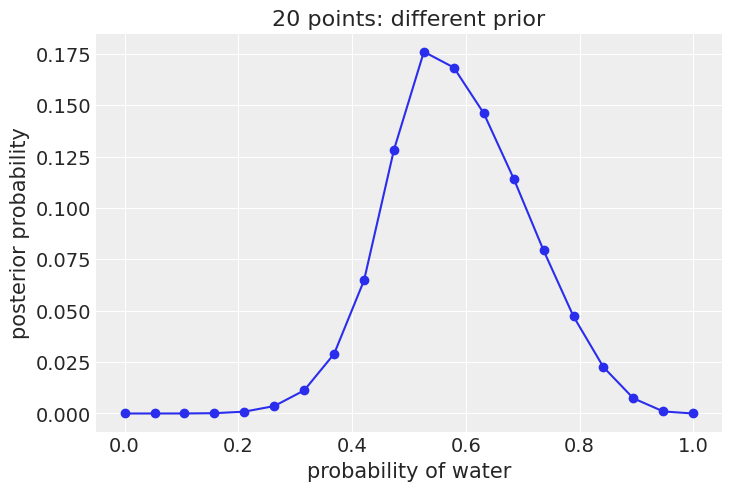

In [10]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points: different prior")
plt.show()

## 2.6. Quadratic approximation

In [11]:
def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=6, L=3)
svi_result = svi.run(random.PRNGKey(0), 1000)
params = svi_result.params

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)

100%|█| 1000/1000 [00:00<00:00, 4145.81it/s, init loss: 2.9278, avg. loss [951-1



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



## 2.7. Analytical calculation

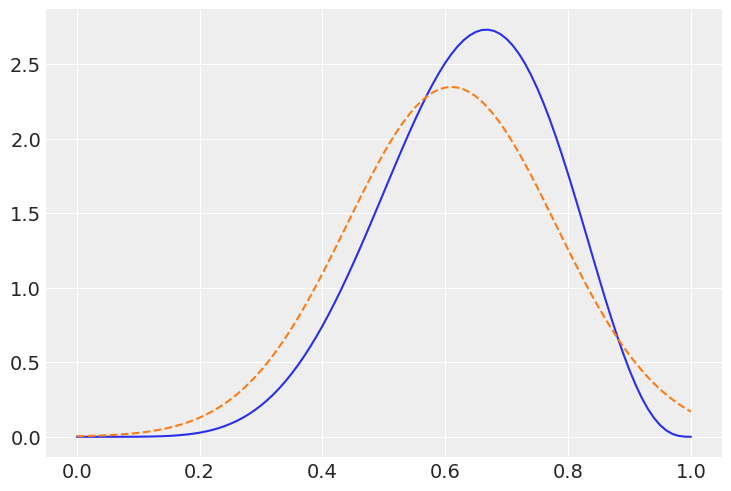

In [12]:
# analytical calculation
W = 6
L = 3
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
plt.plot(x, jnp.exp(dist.Normal(0.61, 0.17).log_prob(x)), "--")
plt.show()

## 2.8. MCMC
Why MCMC
- Grid is too slow
- Fucntion to maximize (when finding the MAP) is not known -> needs to be computed in pieces
- Basic idea: draw samples from posterior
- ends up with a collection of param values, and frequencies of these values correspond to the posterior plausibilities, then you use the histogram of these samples to build a picture of the posterior

In [13]:
n_samples = 1000
p = [jnp.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with numpyro.handlers.seed(rng_seed=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = jnp.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = jnp.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = jnp.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]

## 2.9: comparison between the analytical distribution and MCMC samples

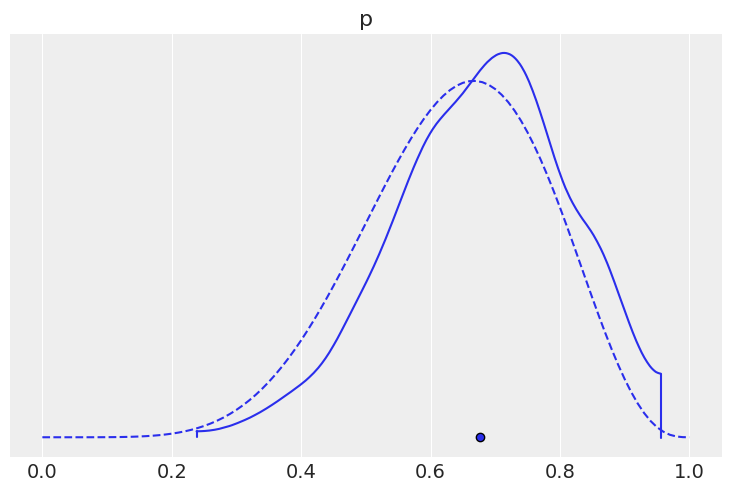

In [14]:
az.plot_density({"p": p}, hdi_prob=1)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "--")
plt.show()